## Diet Recommendation Project: Introduction

This project aims to build a diet recommendation system that suggests meals to users based on their personal profiles, including factors such as gender, weight, height, age, activity level, and dietary goals (e.g., weight loss, muscle gain, or maintaining health). The recommendations are generated using two distinct approaches:

### Approach 1: Neural Networks with Autoencoder Model

In this approach, we utilize a neural network model, specifically an autoencoder, to identify latent features within the dataset. The autoencoder compresses the input data into a lower-dimensional representation, capturing essential characteristics of the recipes. By calculating the cosine similarity between the latent features of different recipes, we can recommend meals that are similar to the user's preferences. This approach leverages the powerful feature extraction capabilities of deep learning, providing personalized and accurate recommendations.

The concept of using an autoencoder for this purpose is inspired by Jason Brownlee's tutorial on "Autoencoder for Classification" available on his website https://machinelearningmastery.com/autoencoder-for-classification/.

### Approach 2: Meal Recommendation Without Machine Learning

The second approach bypasses machine learning models and relies on a more straightforward method to generate recommendations. We calculate the user's Basal Metabolic Rate (BMR) and total daily caloric intake based on their profile. Meals are then recommended by dividing the total daily calories into different proportions for breakfast, lunch, and dinner. Recipes that closely match the calculated caloric targets for each meal are selected from the dataset. This approach ensures that users receive balanced and suitable meal suggestions tailored to their caloric needs.

### Data Source

The data used in this project is sourced from Kaggle and consists of recipes and reviews. The dataset provides a wide variety of food items along with their nutritional information, which is essential for generating accurate and relevant recommendations. The dataset can be accessed from https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews/data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews

Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
100% 723M/723M [00:09<00:00, 44.6MB/s]
100% 723M/723M [00:09<00:00, 82.8MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/foodcom-recipes-and-reviews.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import os  # Operating system interactions

import matplotlib.pyplot as plt # Plotting library
%matplotlib inline

import seaborn as sns  # Statistical data visualization

from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range
from sklearn.model_selection import train_test_split  # Splitting data into training and test sets
from sklearn.metrics.pairwise import cosine_similarity  # Calculating cosine similarity between vectors

import tensorflow as tf  # TensorFlow library for machine learning
from tensorflow.keras.models import Sequential  # Sequential model from Keras
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout  # Layers for the neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for training the model

In [7]:
# Load the dataset from the specified CSV file
# data = pd.read_csv('/kaggle/input/foodcom-recipes-and-reviews/recipes.csv')
data = pd.read_csv('/content/recipes.csv')

# Display the first few rows of the dataset to understand its structure
print(data.isnull().sum())
data.head()

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [8]:
# Create a copy of the original dataset to work with
df = data.copy()

# Display information about the dataset, including column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [9]:
# Select and reorder columns in the dataset for further analysis
selected_columns = ['RecipeId', 'Calories', 'FatContent', 'SaturatedFatContent',
                     'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
                     'FiberContent', 'SugarContent', 'ProteinContent']

# Apply the selected columns to the DataFrame
df = df[selected_columns]

# Display the first few rows of the updated DataFrame
df.head()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,38,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
1,39,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4
2,40,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3
3,41,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3
4,42,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   RecipeId             522517 non-null  int64  
 1   Calories             522517 non-null  float64
 2   FatContent           522517 non-null  float64
 3   SaturatedFatContent  522517 non-null  float64
 4   CholesterolContent   522517 non-null  float64
 5   SodiumContent        522517 non-null  float64
 6   CarbohydrateContent  522517 non-null  float64
 7   FiberContent         522517 non-null  float64
 8   SugarContent         522517 non-null  float64
 9   ProteinContent       522517 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 39.9 MB


In [11]:
df.isnull().sum()

,0
RecipeId,0
Calories,0
FatContent,0
SaturatedFatContent,0
CholesterolContent,0
SodiumContent,0
CarbohydrateContent,0
FiberContent,0
SugarContent,0
ProteinContent,0


In [12]:
df.describe()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
count,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000
mean,271821.436970,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510
std,155495.878422,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837
min,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,137206.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000
50%,271758.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000
75%,406145.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000
max,541383.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000


In [13]:
# Display summary statistics of the DataFrame, including specified percentiles
# Transpose the result for better readability
summary_statistics = df.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T

# Show the summary statistics
summary_statistics


,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
RecipeId,522517.0,271821.436970,155495.878422,38.0,29659.8,56405.6,137206.0,271758.0,406145.0,487592.4,514600.2,541383.0
Calories,522517.0,484.438580,1397.116649,0.0,55.0,90.1,174.2,317.1,529.1,862.8,1305.8,612854.6
FatContent,522517.0,24.614922,111.485798,0.0,0.2,1.2,5.6,13.8,27.4,49.4,75.6,64368.1
SaturatedFatContent,522517.0,9.559457,46.622621,0.0,0.0,0.2,1.5,4.7,10.8,20.3,30.2,26740.6
CholesterolContent,522517.0,86.487003,301.987009,0.0,0.0,0.0,3.8,42.6,107.9,202.3,291.5,130456.4
SodiumContent,522517.0,767.263878,4203.620531,0.0,7.5,28.8,123.3,353.3,792.2,1477.2,2217.1,1246921.1
CarbohydrateContent,522517.0,49.089092,180.822062,0.0,2.4,5.0,12.8,28.2,51.1,86.8,136.8,108294.6
FiberContent,522517.0,3.843242,8.603163,0.0,0.0,0.2,0.8,2.2,4.6,8.6,12.7,3012.0
SugarContent,522517.0,21.878254,142.620191,0.0,0.2,0.8,2.5,6.4,17.9,41.8,71.1,90682.3
ProteinContent,522517.0,17.469510,40.128837,0.0,0.5,1.2,3.5,9.1,25.0,41.3,54.1,18396.2


In [14]:
# Define the columns to filter based on the 95th percentile
filter_columns = ['Calories', 'FatContent', 'SaturatedFatContent',
                   'CholesterolContent', 'SodiumContent',
                   'CarbohydrateContent', 'FiberContent',
                   'SugarContent', 'ProteinContent']

# Compute the 95th percentile values for each specified column
percentile_95_thresholds = df[filter_columns].quantile(0.95)

# Display the 95th percentile thresholds for each column
percentile_95_thresholds

,0.95
Calories,1305.8
FatContent,75.6
SaturatedFatContent,30.2
CholesterolContent,291.5
SodiumContent,2217.1
CarbohydrateContent,136.8
FiberContent,12.7
SugarContent,71.1
ProteinContent,54.1


In [15]:
# Apply filtering to the DataFrame based on the 95th percentile values
filtered_df = df[(df[filter_columns] <= percentile_95_thresholds).all(axis=1)]

# Print the filtered DataFrame
print(filtered_df)

        RecipeId  Calories  FatContent  SaturatedFatContent  \
0             38     170.9         2.5                  1.3   
4             42     103.6         0.4                  0.1   
5             43     437.9        19.3                 10.9   
7             45     228.0         7.1                  1.7   
8             46       4.3         0.0                  0.0   
...          ...       ...         ...                  ...   
522508    541375     422.3        28.6                 12.6   
522509    541376      84.3         2.1                  1.2   
522510    541377     358.9        19.8                 10.5   
522512    541379     316.6        12.5                  7.6   
522515    541382      16.1         0.6                  0.1   

        CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  \
0                      8.0           29.8                 37.1           3.6   
4                      0.0          959.3                 25.1           4.8   
5  

In [16]:
df.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
RecipeId,522517.0,271821.436970,155495.878422,38.0,29659.8,56405.6,137206.0,271758.0,406145.0,487592.4,514600.2,541383.0
Calories,522517.0,484.438580,1397.116649,0.0,55.0,90.1,174.2,317.1,529.1,862.8,1305.8,612854.6
FatContent,522517.0,24.614922,111.485798,0.0,0.2,1.2,5.6,13.8,27.4,49.4,75.6,64368.1
SaturatedFatContent,522517.0,9.559457,46.622621,0.0,0.0,0.2,1.5,4.7,10.8,20.3,30.2,26740.6
CholesterolContent,522517.0,86.487003,301.987009,0.0,0.0,0.0,3.8,42.6,107.9,202.3,291.5,130456.4
SodiumContent,522517.0,767.263878,4203.620531,0.0,7.5,28.8,123.3,353.3,792.2,1477.2,2217.1,1246921.1
CarbohydrateContent,522517.0,49.089092,180.822062,0.0,2.4,5.0,12.8,28.2,51.1,86.8,136.8,108294.6
FiberContent,522517.0,3.843242,8.603163,0.0,0.0,0.2,0.8,2.2,4.6,8.6,12.7,3012.0
SugarContent,522517.0,21.878254,142.620191,0.0,0.2,0.8,2.5,6.4,17.9,41.8,71.1,90682.3
ProteinContent,522517.0,17.469510,40.128837,0.0,0.5,1.2,3.5,9.1,25.0,41.3,54.1,18396.2


In [17]:
# Sample a smaller portion of the data to reduce computational time
# Here, we are selecting a random sample of 6000 rows from the DataFrame 'df'
df = df.sample(6000)

# The purpose of sampling is to work with a manageable subset of the data,
# which helps in reducing computational time and resources for subsequent analysis and modeling.

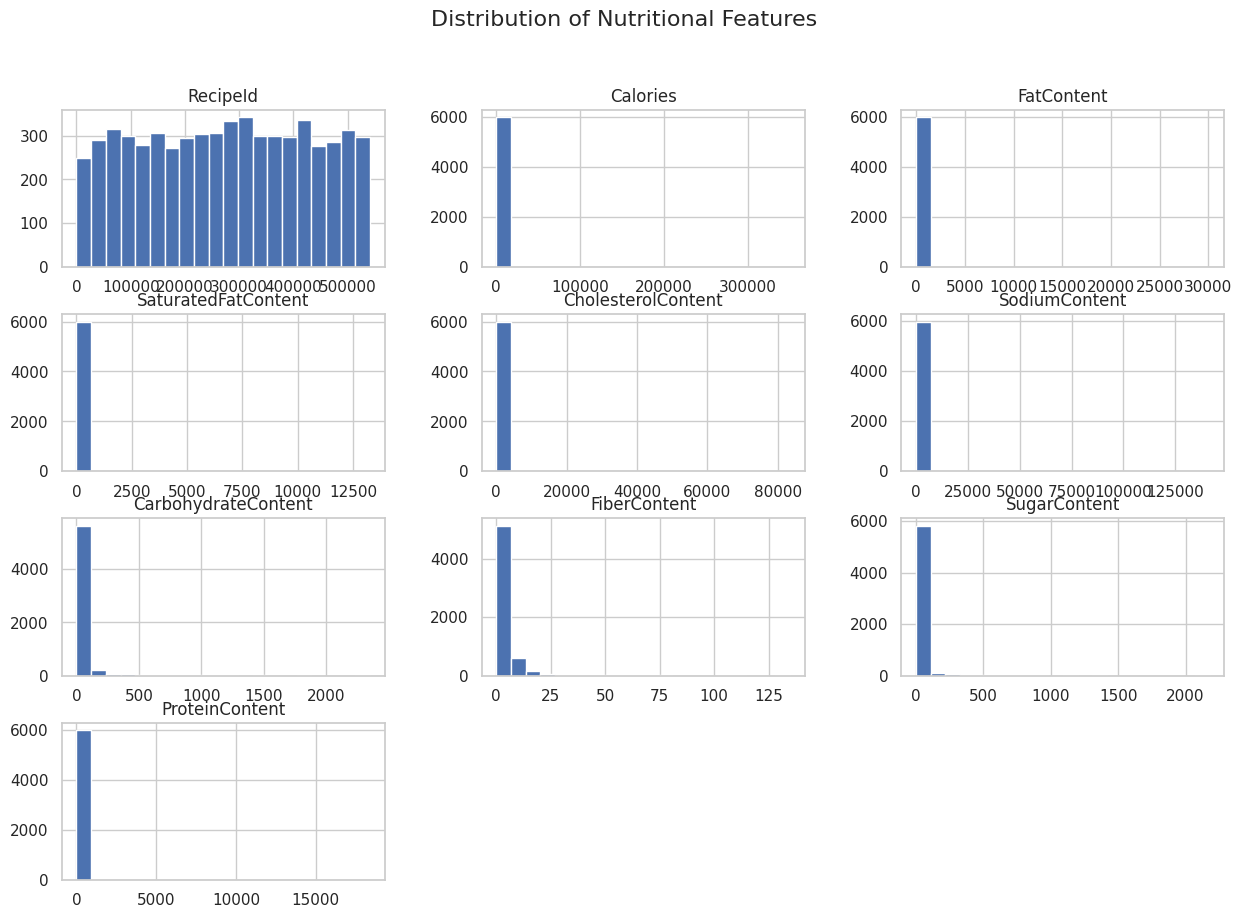

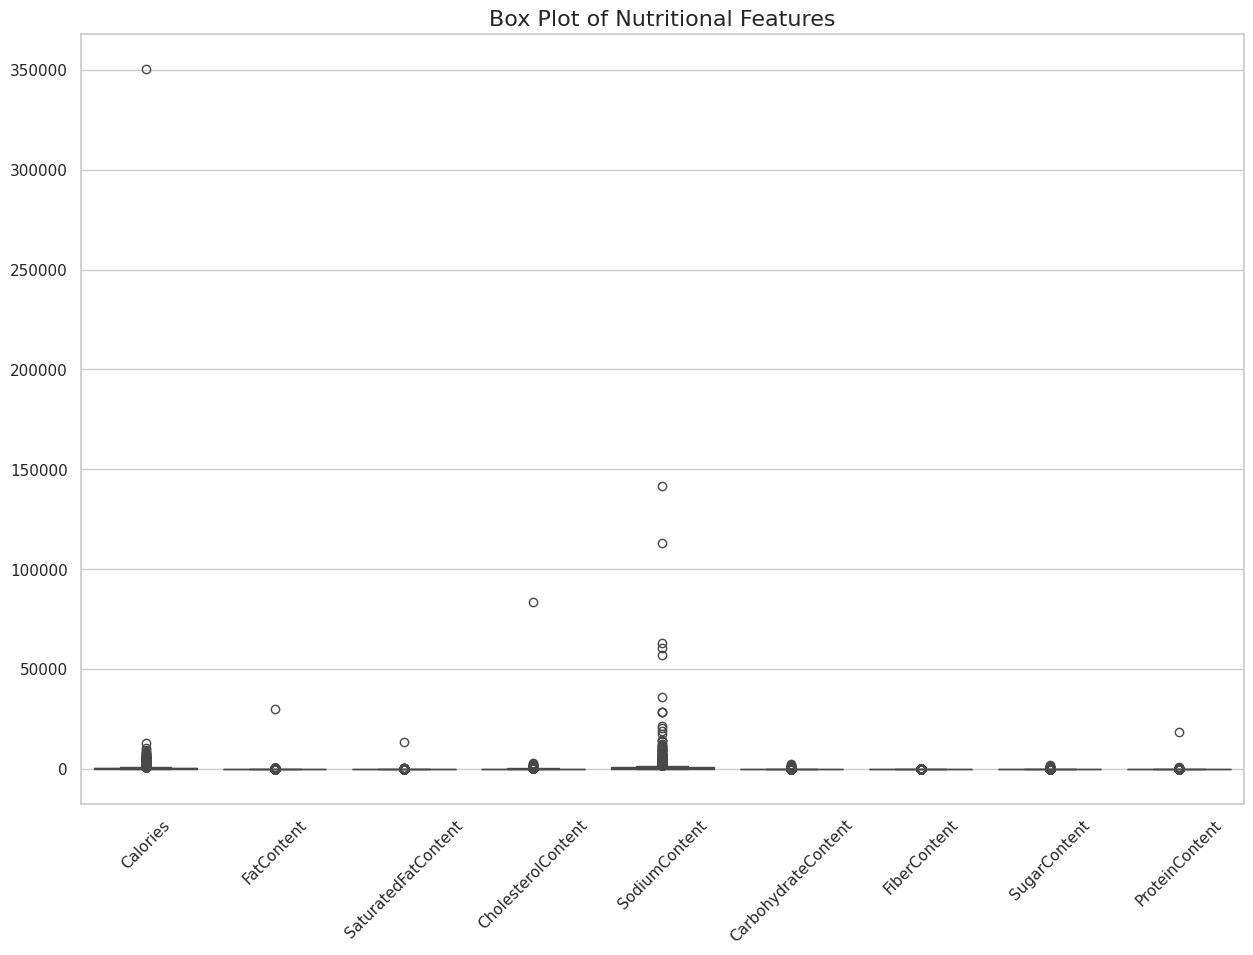

In [18]:
# Set the aesthetic style of the plots to "whitegrid" for better readability
sns.set(style="whitegrid")

# Create histograms for all numerical columns to visualize the distribution of each feature
# The histograms will have 20 bins and a figure size of 15x10 inches
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Nutritional Features', fontsize=16)  # Set the title of the histograms
plt.show()  # Display the histograms

# Create box plots to visualize the distribution and check for outliers in the data
# Drop the 'RecipeId' column as it is not a numerical feature and not needed for this plot
plt.figure(figsize=(15, 10))
sns.boxplot(data=df.drop(columns=['RecipeId']))  # Create the box plot
plt.title('Box Plot of Nutritional Features', fontsize=16)  # Set the title of the box plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the box plot

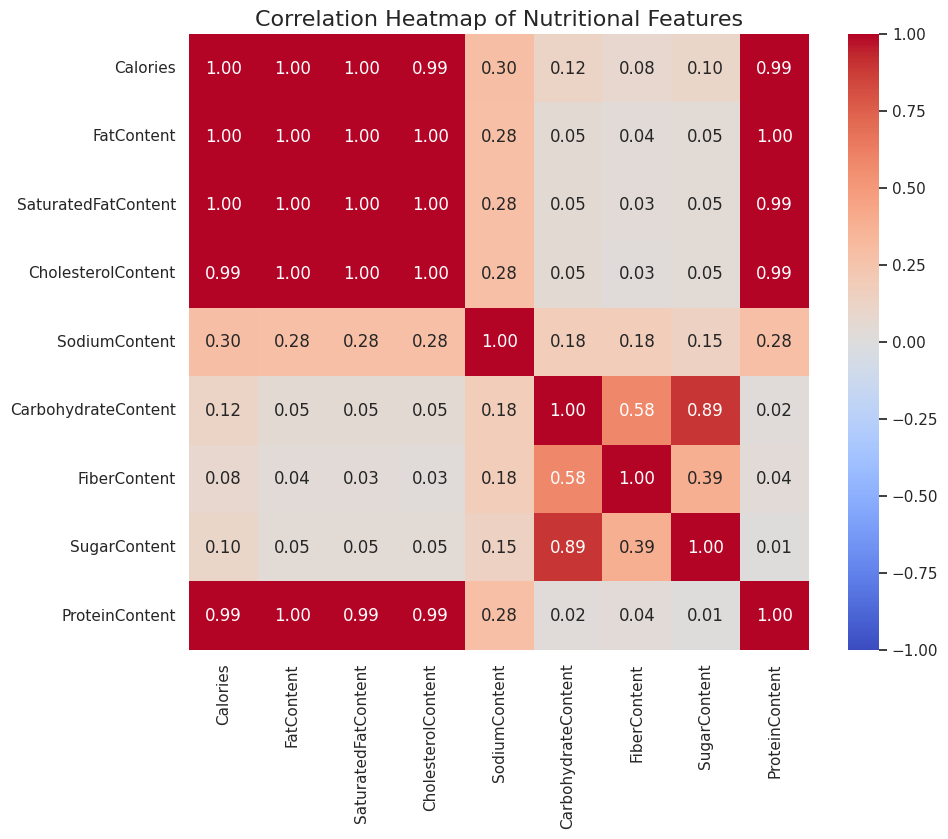

In [19]:
# Compute the correlation matrix for the nutritional features
# The 'RecipeId' column is dropped as it's not a numerical feature and does not contribute to the correlation calculation
corr = df.drop(columns=['RecipeId']).corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size for the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)  # Create the heatmap
# `annot=True` adds the correlation coefficients on the heatmap
# `cmap='coolwarm'` sets the color map to show the correlation values with a gradient from cool to warm
# `fmt='.2f'` formats the correlation values to two decimal places
# `vmin` and `vmax` set the color scale range for better visualization of correlations
plt.title('Correlation Heatmap of Nutritional Features', fontsize=16)  # Set the title of the heatmap
plt.show()  # Display the heatmap

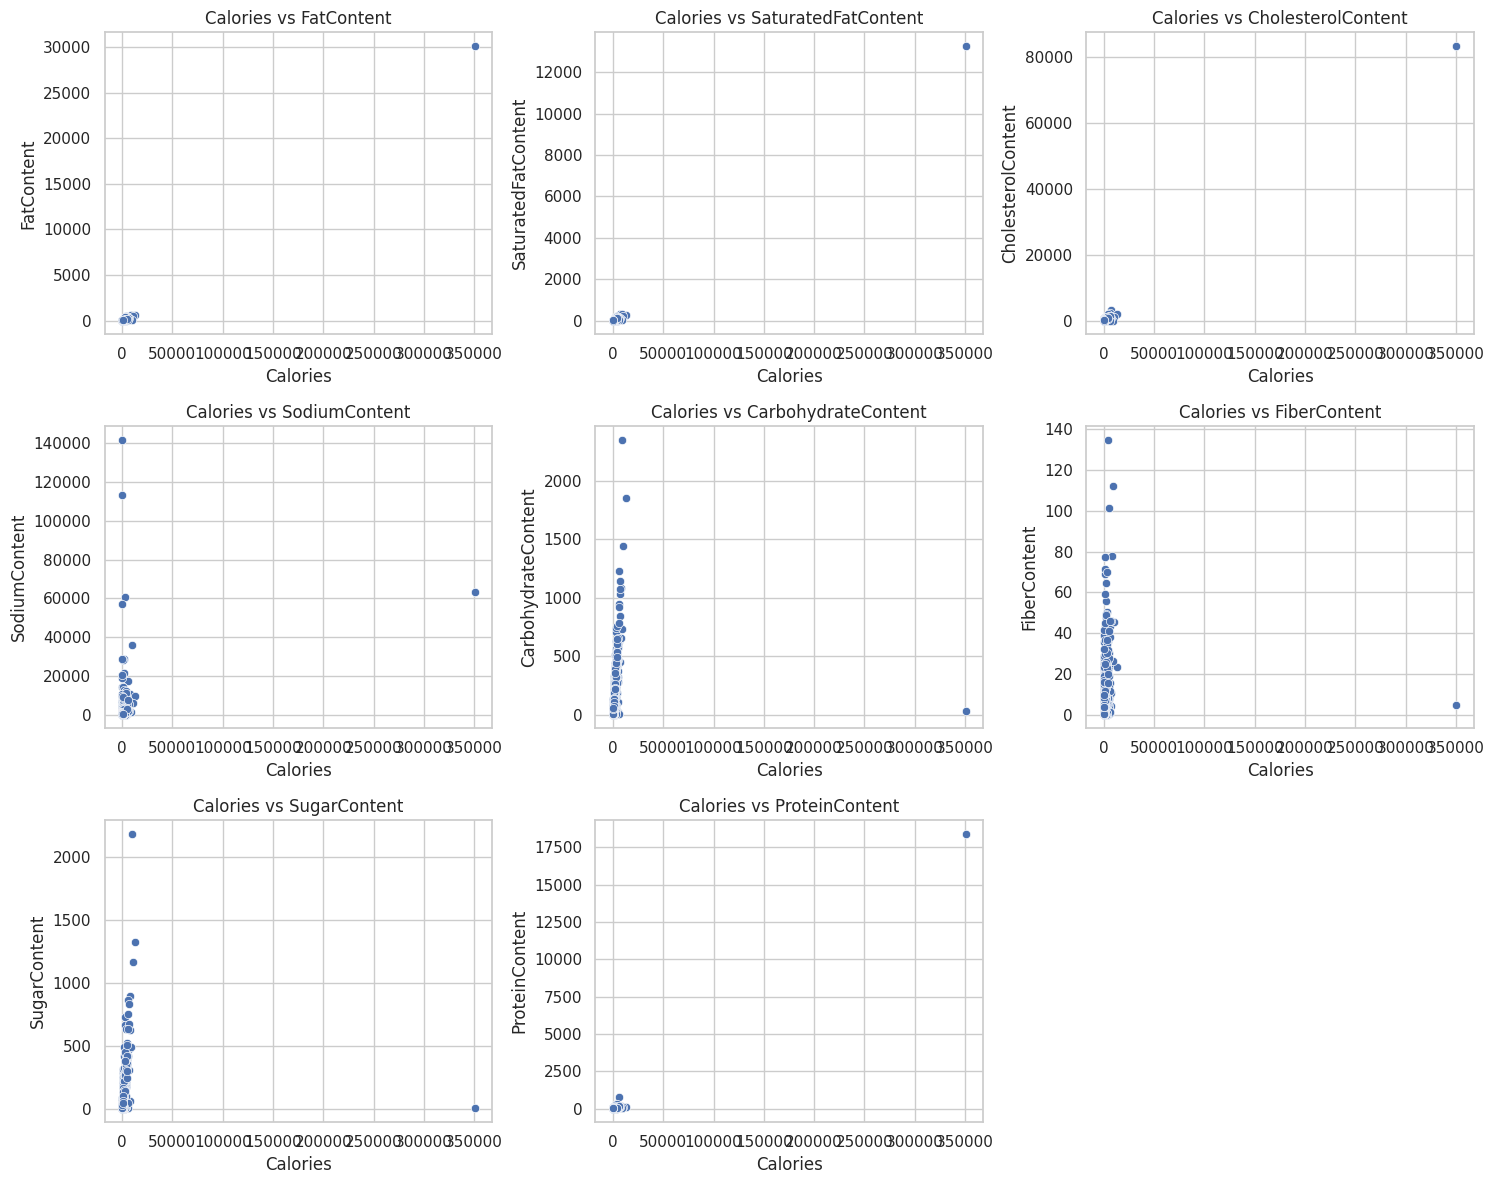

In [20]:
# List of features to compare against 'Calories'
features_to_compare = ['FatContent', 'SaturatedFatContent', 'CholesterolContent',
                       'SodiumContent', 'CarbohydrateContent', 'FiberContent',
                       'SugarContent', 'ProteinContent']

# Set up the figure with a specified size
plt.figure(figsize=(15, 12))

# Loop through each feature and create a scatter plot
for i, feature in enumerate(features_to_compare, 1):
    # Create a subplot for each feature
    plt.subplot(3, 3, i)
    # Generate a scatter plot of 'Calories' vs. the current feature
    sns.scatterplot(x='Calories', y=feature, data=df)
    # Set the title for the scatter plot
    plt.title(f'Calories vs {feature}')

# Adjust subplot parameters for a tight layout
plt.tight_layout()

# Display all the scatter plots
plt.show()

In [21]:
# Drop the 'RecipeId' column from the DataFrame and assign the result to X
X = df.drop(columns=['RecipeId'])

# Assign the 'RecipeId' column to y
y = df['RecipeId']

In [22]:
X.head()

,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
72441,132.9,11.9,7.3,30.5,485.8,4.8,1.5,2.2,4.3
48003,308.9,15.9,5.1,40.9,1252.5,26.5,6.7,6.0,15.9
157027,812.7,24.7,3.6,165.4,4265.1,76.5,0.8,65.9,71.5
484928,376.7,20.3,5.0,303.2,1511.9,13.1,3.4,5.9,35.9
319487,236.3,4.7,1.5,200.2,44.4,35.4,0.2,25.7,5.3


In [23]:
y.head()

,RecipeId
72441,77196
48003,52040
157027,164486
484928,502818
319487,331647


In [24]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to X and transform it
X_scaled = scaler.fit_transform(X)

In [25]:
# Split the already scaled data into training and evaluation sets
X_train_scaled, X_eval_scaled = train_test_split(X_scaled, train_size=0.8, random_state=42)

# Display the shapes of the resulting sets to confirm the split
print("Training set shape:", X_train_scaled.shape)
print("Evaluation set shape:", X_eval_scaled.shape)

Training set shape: (4800, 9)
Evaluation set shape: (1200, 9)


In [26]:
# Neural Network Model Architecture
num_features = X_train_scaled.shape[1]  # Number of features in the input data

# Define the autoencoder model
model = Sequential([
    # Encoder
    Dense(256, input_shape=(num_features,)),  # Input layer with 256 neurons
    LeakyReLU(),  # Activation function with a small slope for negative inputs
    Dropout(0.2),  # Dropout layer with 20% dropout rate to prevent overfitting
    Dense(128),  # Hidden layer with 128 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer
    Dense(64),  # Hidden layer with 64 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer

    # Bottleneck
    Dense(32),  # Bottleneck layer with 32 neurons, this is the compressed representation of the input data
    # The bottleneck layer reduces the dimensionality of the input data, capturing essential features

    # Decoder
    Dense(64),  # Hidden layer in the decoder with 64 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer
    Dense(128),  # Hidden layer with 128 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer
    Dense(256),  # Hidden layer with 256 neurons
    LeakyReLU(),  # Activation function

    # Output layer
    Dense(num_features, activation='linear')  # Output layer with the same number of neurons as features, linear activation
    # The linear activation function in the output layer allows the network to reconstruct the input data directly
])

# Summary of the model to check the architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,561 (357.66 KB)

 Trainable params: 91,561 (357.66 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Define the optimizer with a learning rate
optimizer = Adam(learning_rate=0.0001)

In [28]:
# Compile the model
model.compile(optimizer=optimizer,
              loss='mse',  # Mean Squared Error for regression
              metrics=['mae'])  # Mean Absolute Error for regression evaluation

In [29]:
# Fit the model with scaled training data as both input and target
training_history = model.fit(X_train_scaled, X_train_scaled,
                             validation_data=(X_eval_scaled, X_eval_scaled),
                             epochs=10)

# Extract validation loss from the training history
validation_loss = training_history.history['val_loss']

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.1611e-04 - mae: 0.0070 - val_loss: 1.3307e-04 - val_mae: 0.0040
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1871e-04 - mae: 0.0047 - val_loss: 5.8038e-05 - val_mae: 0.0028
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3941e-04 - mae: 0.0041 - val_loss: 3.0726e-05 - val_mae: 0.0024
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6592e-04 - mae: 0.0038 - val_loss: 2.6531e-05 - val_mae: 0.0023
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4719e-04 - mae: 0.0038 - val_loss: 2.3779e-05 - val_mae: 0.0022
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2504e-04 - mae: 0.0035 - val_loss: 3.1891e-05 - val_mae: 0.0028
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3094e-04 - mae: 0.0036 - val_loss: 1.9943e-05 - val_mae: 0.0020
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5632e-05 - mae: 0.0033 - val_loss: 1.8620e-05 - val_mae:

In [30]:
# Predict latent features using the trained model
predicted_latent_features = model.predict(X_scaled)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [31]:
X_scaled.shape

(6000, 9)

In [32]:
predicted_latent_features.shape

(6000, 9)

In [33]:
X_scaled[0:5,]

array([[0.0003792 , 0.00039504, 0.00055014, 0.00036569, 0.00342965,
        0.00204151, 0.0111276 , 0.00100996, 0.00023374],
       [0.00088138, 0.00052782, 0.00038434, 0.00049038, 0.0088424 ,
        0.01127084, 0.04970326, 0.00275444, 0.00086431],
       [0.00231887, 0.00081995, 0.0002713 , 0.00198311, 0.03011075,
        0.03253658, 0.00593472, 0.03025295, 0.00388667],
       [0.00107483, 0.00067389, 0.00037681, 0.0036353 , 0.01067371,
        0.00557162, 0.02522255, 0.00270853, 0.00195149],
       [0.00067423, 0.00015602, 0.00011304, 0.00240035, 0.00031346,
        0.01505614, 0.00148368, 0.01179819, 0.0002881 ]])

In [34]:
predicted_latent_features[0:5,]

array([[ 0.00037059,  0.00014924,  0.0007371 ,  0.00118416,  0.00268912,
         0.00441507,  0.00718023,  0.00180002,  0.00064766],
       [ 0.00161851,  0.00182348,  0.00086859,  0.00078211,  0.00413162,
         0.01269472,  0.04205073,  0.00233364,  0.00125322],
       [ 0.0007157 ,  0.00102568, -0.00013245,  0.00094081,  0.00852236,
         0.02834296,  0.00557111,  0.02113498,  0.00032942],
       [ 0.00099176,  0.00134627,  0.0008113 ,  0.00136873,  0.00532728,
         0.00749171,  0.02090038,  0.00095176,  0.00087025],
       [-0.00039921, -0.00026492, -0.00044086,  0.00044908,  0.00234346,
         0.01406332,  0.0019588 ,  0.01114067,  0.00015697]],
      dtype=float32)

In [35]:
# Manual calculation of cosine similarity

# Compute the Dot Product:
# This calculates the dot product between each pair of latent feature vectors.
# The result is a matrix where each entry represents the dot product (or similarity) between two feature vectors.
similarity_matrix = np.dot(predicted_latent_features, predicted_latent_features.T)

# Calculate the Norms:
# The norm (or magnitude) of each latent feature vector is calculated.
# 'axis=1' indicates that the norm is computed for each row (each feature vector).
# 'keepdims=True' keeps the dimensions of the output the same for broadcasting purposes.
norms = np.linalg.norm(predicted_latent_features, axis=1, keepdims=True)

# Normalize the Similarity Matrix:
# Each entry in the similarity matrix is divided by the product of the norms of the vectors being compared.
# This normalizes the similarity scores to cosine similarity, which ranges from -1 to 1.
similarity_matrix /= np.dot(norms, norms.T)

# Print the shape of the similarity matrix to confirm dimensions
print(similarity_matrix.shape)

(6000, 6000)


In [36]:
print(similarity_matrix[0:5,0:6])

[[1.         0.9275578  0.67457044 0.96116334 0.6145274  0.8636825 ]
 [0.9275578  0.99999976 0.4186216  0.98754734 0.36645812 0.7128852 ]
 [0.67457044 0.4186216  0.99999994 0.47000092 0.9910838  0.92623276]
 [0.96116334 0.98754734 0.47000092 1.0000001  0.40366513 0.73314506]
 [0.6145274  0.36645812 0.9910838  0.40366513 0.99999994 0.9118034 ]]


In [37]:
# Calculation of cosine similarity using sklearn library
# The `cosine_similarity` function computes the cosine similarity between each pair of feature vectors.
# It automatically handles normalization and computes the similarity matrix.
similarity_matrix_sklearn = cosine_similarity(predicted_latent_features)

# Print the shape of the similarity matrix to confirm dimensions
print(similarity_matrix_sklearn.shape)


(6000, 6000)


In [38]:
print(similarity_matrix[0:5,0:6])

[[1.         0.9275578  0.67457044 0.96116334 0.6145274  0.8636825 ]
 [0.9275578  0.99999976 0.4186216  0.98754734 0.36645812 0.7128852 ]
 [0.67457044 0.4186216  0.99999994 0.47000092 0.9910838  0.92623276]
 [0.96116334 0.98754734 0.47000092 1.0000001  0.40366513 0.73314506]
 [0.6145274  0.36645812 0.9910838  0.40366513 0.99999994 0.9118034 ]]


In [39]:
# Initialize a dictionary to store recommendations
recommendations_dict = {}

# Iterate over each item in the dataset
for item_index in range(len(X_scaled)):
    # Sort indices based on similarity in descending order
    sorted_indices = similarity_matrix[item_index].argsort()[::-1]

    # Create a list of tuples with similarity scores and indices, excluding the item itself
    similar_items_list = [(similarity_matrix[item_index][idx], idx) for idx in sorted_indices if idx != item_index]

    # Store the list of similar items for the current item in the recommendations dictionary
    recommendations_dict[item_index] = similar_items_list

In [40]:
# Define the number of items to display from the recommendations
items_to_display = 10

# Iterate through the first 'items_to_display' entries in the recommendations dictionary
for index, (item_id, similar_items) in enumerate(recommendations_dict.items()):
    if index < items_to_display:
        # Print the item ID and its list of similar items
        print(f"Item {item_id}: {similar_items}")
        # Print a separator for better readability
        print('*' * 100)
    else:
        # Stop iterating once the desired number of items have been displayed
        break

Item 0: [(0.99983484, 1782), (0.9995829, 1623), (0.999455, 2548), (0.99941754, 450), (0.9994004, 3189), (0.9993117, 4946), (0.9992793, 4763), (0.9992206, 1442), (0.9992194, 189), (0.9991869, 3646), (0.9991657, 3847), (0.99913883, 5916), (0.9991252, 4128), (0.9991018, 4359), (0.9990781, 4336), (0.9990479, 3845), (0.9989731, 1778), (0.9989687, 5917), (0.9989515, 5824), (0.9988614, 3129), (0.99885535, 3279), (0.9988488, 3185), (0.9988213, 3644), (0.9988131, 5026), (0.998811, 5705), (0.9987555, 4720), (0.99871165, 484), (0.99870485, 5964), (0.998676, 4514), (0.9986503, 1261), (0.998638, 2695), (0.9986076, 4246), (0.9985544, 2642), (0.9984933, 818), (0.99844426, 252), (0.99840003, 1916), (0.99839103, 4262), (0.99838203, 2232), (0.998367, 1786), (0.99830616, 1123), (0.9982937, 2942), (0.99829143, 3227), (0.9982426, 2382), (0.99820566, 2008), (0.99810666, 36), (0.9981027, 5931), (0.9980683, 5961), (0.9980613, 2088), (0.99802697, 2352), (0.9980242, 811), (0.99799836, 2585), (0.99796164, 260), 

Reference: <br> https://www.maxhealthcare.in/calculator/bmr#:~:text=The%20Mifflin%20St%20Jeor%20equation,age%20in%20years)%20%2D%20161.

The Mifflin St Jeor equation based formula is <br>
 For Men: BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) + 5. <br>
 For Women:BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) - 161. <br>

In [41]:
# Calculate Basal Metabolic Rate (BMR)
def compute_bmr(gender, body_weight, body_height, age):
    """
    Calculate Basal Metabolic Rate (BMR) based on gender, body weight, body height, and age.

    Args:
        gender (str): Gender of the individual ('male' or 'female').
        body_weight (float): Body weight of the individual in kilograms.
        body_height (float): Body height of the individual in centimeters.
        age (int): Age of the individual in years.

    Return:
        float: Basal Metabolic Rate (BMR) value.
    """
    if gender == 'male':
        # For Men: BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) + 5
        bmr_value = 10 * body_weight + 6.25 * body_height - 5 * age + 5
    elif gender == 'female':
        # For Women: BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) - 161
        bmr_value = 10 * body_weight + 6.25 * body_height - 5 * age - 161
    else:
        raise ValueError("Invalid gender. Please choose 'male' or 'female'.")
    return bmr_value

Reference: <br>
https://www.k-state.edu/paccats/Contents/PA/PDF/Physical%20Activity%20and%20Controlling%20Weight.pdf <br>


Sedentary = BMR x 1.2 (little or no exercise, desk job) <br>
Lightly active = BMR x 1.375 (light exercise/ sports 1-3 days/week) <br>
Moderately active = BMR x 1.55 (moderate exercise/ sports 6-7 days/week) <br>
Very active = BMR x 1.725 (hard exercise every day, or exercising 2 xs/day) <br>
Extra active = BMR x 1.9 (hard exercise 2 or more times per day, or training formarathon, or triathlon, etc <br>

In [42]:
def compute_daily_caloric_intake(bmr, activity_intensity, objective):
    """
    Calculate total daily caloric intake based on Basal Metabolic Rate (BMR), activity level, and personal goal.

    Args:
        bmr (float): Basal Metabolic Rate (BMR) value.
        activity_intensity (str): Activity level of the individual ('sedentary', 'lightly_active', 'moderately_active', 'very_active', 'extra_active').
        objective (str): Personal goal of the individual ('weight_loss', 'muscle_gain', 'health_maintenance').

    Return:
        int: Total daily caloric intake.
    """
    # Define activity multipliers based on intensity
    intensity_multipliers = {
        'sedentary': 1.2,
        'lightly_active': 1.375,
        'moderately_active': 1.55,
        'very_active': 1.725,
        'extra_active': 1.9
    }

    # Define goal adjustments based on objective
    objective_adjustments = {
        'weight_loss': 0.8,
        'muscle_gain': 1.2,
        'health_maintenance': 1
    }

    # Calculate maintenance calories based on activity intensity
    maintenance_calories = bmr * intensity_multipliers[activity_intensity]

    # Adjust maintenance calories based on personal objective
    total_caloric_intake = maintenance_calories * objective_adjustments[objective]

    return round(total_caloric_intake)

In [43]:
def suggest_recipes(category, body_weight, body_height, age, activity_intensity, objective):
    """
    Generate food recommendations based on the user's profile and dietary goals.

    Args:
        category (str): Gender category of the user ('male' or 'female').
        body_weight (float): Weight of the user in kilograms.
        body_height (float): Height of the user in centimeters.
        age (int): Age of the user in years.
        activity_intensity (str): Physical activity level of the user ('sedentary', 'lightly_active', 'moderately_active', 'very_active', 'extra_active').
        objective (str): Dietary objective of the user ('weight_loss', 'muscle_gain', 'health_maintenance').

    Return:
        pd.DataFrame: Recommended recipes including name and calorie content.
    """
    # Calculate the Basal Metabolic Rate (BMR) for the user
    bmr = compute_bmr(category, body_weight, body_height, age)

    # Calculate the total daily caloric intake based on activity intensity and dietary objective
    total_calories = compute_daily_caloric_intake(bmr, activity_intensity, objective)

    # Prepare input data for the model with desired total calories
    user_input_features = np.array([[total_calories, 0, 0, 0, 0, 0, 0, 0, 0]])

    # Scale the input data to match the model's training scale
    scaled_input_features = scaler.transform(user_input_features)

    # Predict latent features for the input data
    predicted_latent_features = model.predict(scaled_input_features)

    # Find the index with the highest prediction probability
    top_prediction_index = np.argmax(predicted_latent_features.flatten())

    # Retrieve recommended recipes based on the highest prediction
    similar_recipe_indices = np.array(recommendations_dict[top_prediction_index])
    recommended_recipes = data.iloc[similar_recipe_indices[:, 1].astype(int)][['Name', 'Calories']]

    return recommended_recipes.head(10)  # Return the top 5 recommended recipes

In [44]:
# Define the input values
user_category = 'female'
user_body_weight = 80  # in kilograms
user_body_height = 170  # in centimeters
user_age = 50  # in years
user_activity_intensity = 'moderately_active'
user_objective = 'weight_loss'

# Generate suggested recipes
suggested_recipes = suggest_recipes(
    category=user_category,
    body_weight=user_body_weight,
    body_height=user_body_height,
    age=user_age,
    activity_intensity=user_activity_intensity,
    objective=user_objective
)

# Calculate required daily calories
required_calories = compute_daily_caloric_intake(
    bmr=compute_bmr(user_category, user_body_weight, user_body_height, user_age),
    activity_intensity=user_activity_intensity,
    objective=user_objective
)

# Print the required calories
print(f"Required Daily Calories: {required_calories}\n")
print("Top 5 Suggested Recipes:\n")

# Print the suggested recipes in a readable format
for idx, recipe in suggested_recipes.iterrows():
    print(f"{idx + 1}. {recipe['Name']} - {recipe['Calories']} Calories")
    print('-' * 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Required Daily Calories: 1800

Top 5 Suggested Recipes:

5804. Spicy Green Rice - 517.4 Calories
----------------------------------------
4119. Celery Seed Dressing II - 347.8 Calories
----------------------------------------
572. Crawfish or Shrimp Cocktail - 169.3 Calories
----------------------------------------
3468. Akoori - Indian Scrambled Eggs - 246.8 Calories
----------------------------------------
1417. Sicilian Sausage Bread - 506.0 Calories
----------------------------------------
3231. Finnish Almond Cookies - 2207.3 Calories
----------------------------------------
103. Cheese Rolls - 66.5 Calories
----------------------------------------
1479. Christmas Puddings - 403.7 Calories
----------------------------------------
723. Red Pepper Spoon Bread - 212.4 Calories
----------------------------------------
3570. Very Cheesy Casserole - 330.2 Calories
----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## Meal Recommendation System Without Machine Learning

In this approach, we make food recommendations based on a user's profile and preferences without using machine learning or artificial neural networks. Instead, we calculate the Basal Metabolic Rate (BMR) and total daily caloric intake based on the user's gender, weight, height, age, activity level, and goal (e.g., weight loss, muscle gain, or maintaining health).

We then suggest meals for breakfast, lunch, and dinner by filtering recipes that closely match the calculated caloric targets for each meal. The meals are divided into different proportions of the total daily calories:

- **Breakfast**: 50% of daily calories
- **Lunch**: 40% of daily calories
- **Dinner**: 10% of daily calories

Recipes are recommended within a specified tolerance range of the target calories for each meal.


In [45]:
def find_recipes_near_target(caloric_goal, recipes_df, tolerance=50):
    """
    Find recipes close to the caloric goal.

    Args:
        caloric_goal (int): Target calories for the meal.
        recipes_df (pd.DataFrame): DataFrame containing recipe names and calories.
        tolerance (int): Allowable difference from the target calories.

    Returns:
        pd.DataFrame: Recommended recipes close to the caloric goal.
    """
    # Filter recipes within the tolerance range of the caloric goal
    matching_recipes = recipes_df[(recipes_df['Calories'] >= caloric_goal - tolerance) &
                                  (recipes_df['Calories'] <= caloric_goal + tolerance)]

    # Return an empty DataFrame if no recipes match the caloric goal
    if matching_recipes.empty:
        return pd.DataFrame()

    return matching_recipes

In [46]:
def generate_meal_plan(category, body_weight, body_height, age, activity_intensity, objective, recipes_df, tolerance=50):
    """
    Generate food recommendations based on user profile and dietary goals.

    Args:
        category (str): Gender of the user ('male' or 'female').
        body_weight (float): Weight of the user in kilograms.
        body_height (float): Height of the user in centimeters.
        age (int): Age of the user in years.
        activity_intensity (str): Physical activity level of the user ('sedentary', 'lightly_active',
                                  'moderately_active', 'very_active', 'extra_active').
        objective (str): Dietary goal of the user ('weight_loss', 'muscle_gain', 'maintain_health').
        recipes_df (pd.DataFrame): DataFrame containing recipe names and calories.
        tolerance (int): Allowable difference from the target calories.

    Returns:
        None
    """
    # Calculate the Basal Metabolic Rate (BMR)
    bmr_value = compute_bmr(category, body_weight, body_height, age)

    # Calculate the total daily caloric intake based on activity intensity and goal
    daily_caloric_intake = compute_daily_caloric_intake(bmr_value, activity_intensity, objective)

    # Define the proportions of daily calories for each meal
    meal_proportions = {'breakfast': 0.50, 'lunch': 0.40, 'dinner': 0.10}

    # Calculate caloric targets for each meal
    caloric_targets = {meal: int(daily_caloric_intake * prop) for meal, prop in meal_proportions.items()}

    # Get recipe recommendations for each meal
    breakfast_options = find_recipes_near_target(caloric_targets['breakfast'], recipes_df, tolerance)
    lunch_options = find_recipes_near_target(caloric_targets['lunch'], recipes_df, tolerance)
    dinner_options = find_recipes_near_target(caloric_targets['dinner'], recipes_df, tolerance)

    # Print the recommended recipes for each meal
    print("Breakfast Recommendations:")
    if not breakfast_options.empty:
        print(breakfast_options[['Name', 'Calories']].head(3))  # Display the top 3 matching recipes
    else:
        print("No suitable recipes found.")

    print("\nLunch Recommendations:")
    if not lunch_options.empty:
        print(lunch_options[['Name', 'Calories']].head(3))  # Display the top 3 matching recipes
    else:
        print("No suitable recipes found.")

    print("\nDinner Recommendations:")
    if not dinner_options.empty:
        print(dinner_options[['Name', 'Calories']].head(3))  # Display the top 3 matching recipes
    else:
        print("No suitable recipes found.")

In [47]:
# Define user profile and dietary goal
category = 'male'  # Gender of the user
body_weight = 80   # Weight of the user in kilograms
body_height = 170  # Height of the user in centimeters
age = 46           # Age of the user in years
activity_intensity = 'moderately_active'  # Physical activity level of the user
objective = 'weight_loss'  # Dietary goal of the user

# Define tolerance for caloric matching
tolerance = 50  # Allowable difference from the target calories


# Generate meal plan using the provided function
generate_meal_plan(
    category=category,
    body_weight=body_weight,
    body_height=body_height,
    age=age,
    activity_intensity=activity_intensity,
    objective=objective,
    recipes_df=data,
    tolerance=tolerance
)

Breakfast Recommendations:
                      Name  Calories
49         Almond Joy Cake    1001.4
64      Cajun Beef Burgers    1012.8
78  Commissary Carrot Cake    1011.8

Lunch Recommendations:
                                  Name  Calories
27         Black Coffee Barbecue Sauce     772.0
150  Citrus Glazed Barbecued Pork Loin     835.8
167      Chocolate Chip Cheesecake Dip     779.0

Dinner Recommendations:
                                          Name  Calories
0            Low-Fat Berry Blue Frozen Dessert     170.9
7   Buttermilk Pie With Gingersnap Crumb Crust     228.0
21                   Lou's Fabulous Bruschetta     221.5
